In [1]:
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

np.random.seed(42)


def density_matrix(state):
    return state * np.conj(state).T


label_0 = [[1],[0]]
label_1 = [[0],[1]]

state_labels = [label_0, label_1]

In [48]:
density_matrix(state_labels[1])

array([[0, 0],
       [0, 1]])

In [49]:
X_tra = []
Y_ans = []
with open('data.txt', 'r') as f:
    x = f.readlines()
x
for i in range(len(x)):
    x[i] = x[i][:-1]
    x[i] = x[i].split(' ')
    X_tra.append(x[i][:-1])
    Y_ans.append(x[i][-1:])
X_tra
ans = []
for i in range(len(Y_ans)):
    if(Y_ans[i]==min(Y_ans)):
        Y_ans[i]=['0']
    ans.append(Y_ans[i][0])
for i in range(len(X_tra)):
    ans[i]=int(ans[i])
    for j in range(len(X_tra[i])):
        X_tra[i][j]=float(X_tra[i][j])

In [50]:
print(scaler.fit(X_tra))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [51]:
X_tra = scaler.transform(X_tra)

In [52]:
len(X_tra)

320

In [53]:
dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev)
def qcircuit(params, x=None, y=None):
    for i in range(len(params)):
        qml.Rot(x[0]*(math.pi)/2,x[1]*(math.pi)/2,x[2]*(math.pi)/2, wires=0)
        qml.Rot(params[i][0]*(math.pi)/2,params[i][1]*(math.pi)/2,params[i][2]*(math.pi)/2, wires=0)
        qml.Rot(0,x[2]*(math.pi)/2,x[3]*(math.pi)/2, wires=1)
        qml.Rot(x[6]*(math.pi)/2,x[7]*(math.pi)/2,x[8]*(math.pi)/2, wires=2)
        qml.Rot(x[9]*(math.pi)/2,x[10]*(math.pi)/2,0, wires=3)
        qml.Rot(x[3]*(math.pi)/2,0,0,wires=0)
        qml.Rot(params[i][3]*(math.pi)/2,0,0, wires=0)
        qml.Rot(params[i][6]*(math.pi)/2,params[i][7]*(math.pi)/2,params[i][8]*(math.pi)/2, wires=2)
        qml.Rot(params[i][9]*(math.pi)/2,params[i][10]*(math.pi)/2,params[i][11]*(math.pi)/2, wires=3)
        if i== len(params) -1 :
          break
        qml.Hadamard(wires=1)
        qml.CNOT(wires=[0,1])
        qml.Hadamard(wires=1)
    return qml.expval(qml.Hermitian(y, wires=[0]))


def fidelity(state1, state2):
    return np.abs(np.dot(np.conj(state1), state2))


def cost(params, x, y, state_labels=None):
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

Utility functions for testing and creating batches
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [54]:
def test(params, x, y, state_labels=None):
    fidelity_values = []
    output_states = []
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        output_states.append(dev._state)
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states

def test1(params, x, y, state_labels=None):
    fidelity_values = []
    output_states = []
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        output_states.append(dev._state)
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states


def predicted_labels(states, state_labels=None):
    output_labels = [
        np.argmax([fidelity(s, label) for label in state_labels]) for s in states
    ]
    return np.array(output_labels)


def accuracy_score(y_true, y_pred):
    score=0
    for i in range(len(y_true)):
        if(y_true[i]==y_pred[i]):
            score=score+1;
    return score / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

In [55]:
Xdata, Xtest, y_train, y_test = train_test_split(X_tra, ans, test_size=0.33)
Xdata = np.array(Xdata)
Xtest = np.array(Xtest)

Train a quantum classifier on the circle dataset
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



In [56]:
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))


# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 7
batch_size = 32

trial_no =[]
cost_arr=[]
Test_Accu_arr=[]
Train_Accu_arr=[]

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 4))
print(params)
predicted_train, states_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, states_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test))

trial_no.append(0)
cost_arr.append(loss)
Train_Accu_arr.append(accuracy_train)
Test_Accu_arr.append(accuracy_test)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, states_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    trial_no.append(it+1)
    cost_arr.append(loss)
    Train_Accu_arr.append(accuracy_train)
    Test_Accu_arr.append(accuracy_test)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, states_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res))

[[0.57229247 0.98033158 0.07534626 0.30569702]
 [0.19091103 0.26847486 0.48527987 0.37268687]
 [0.39469147 0.84421314 0.93001683 0.07041613]]
Epoch:  0 | Cost: 0.569724 | Train accuracy: 0.252336 | Test Accuracy: 0.245283
Epoch:  1 | Loss: 0.259421 | Train accuracy: 0.490654 | Test accuracy: 0.518868
Epoch:  2 | Loss: 0.193961 | Train accuracy: 0.495327 | Test accuracy: 0.509434
Epoch:  3 | Loss: 0.200659 | Train accuracy: 0.813084 | Test accuracy: 0.811321
Epoch:  4 | Loss: 0.111603 | Train accuracy: 0.948598 | Test accuracy: 0.915094
Epoch:  5 | Loss: 0.089432 | Train accuracy: 0.859813 | Test accuracy: 0.905660
Epoch:  6 | Loss: 0.041069 | Train accuracy: 1.000000 | Test accuracy: 1.000000
Epoch:  7 | Loss: 0.020537 | Train accuracy: 1.000000 | Test accuracy: 1.000000


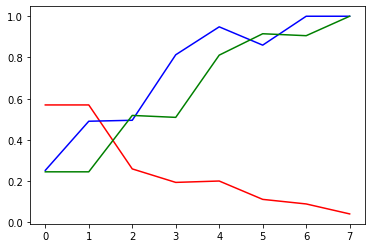

In [57]:
plt.plot(trial_no, cost_arr,'r', trial_no, Train_Accu_arr,'b', trial_no,Test_Accu_arr,'g')

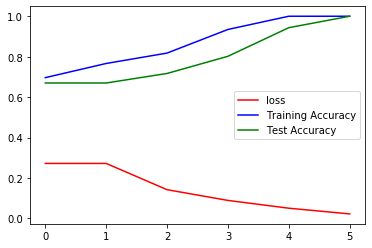

In [36]:
plt.plot(trial_no, cost_arr, label='loss',color='r')
plt.plot(trial_no, Train_Accu_arr,color='b', label='Training Accuracy')
plt.plot(trial_no, Test_Accu_arr,color='g', label='Test Accuracy')
plt.legend()
plt.savefig('image2.jpg')

Results
~~~~~~~



In [ ]:
#print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
 #       loss, accuracy_train, accuracy_test))

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))




References
----------
[1] Pérez-Salinas, Adrián, et al. “Data re-uploading for a universal
quantum classifier.” arXiv preprint arXiv:1907.02085 (2019).

[2] Kingma, Diederik P., and Ba, J. "Adam: A method for stochastic
optimization." arXiv preprint arXiv:1412.6980 (2014).

[3] Liu, Dong C., and Nocedal, J. "On the limited memory BFGS
method for large scale optimization." Mathematical programming
45.1-3 (1989): 503-528.

